# MAWI label/ground truth extraction and analysis

In [9]:
# define librabries
import sys
import admd
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Anomaly label extraction 

Labels are extracted from MAWI admd(.xml) files using an admd.py script, you may find more at the MAWIlab project website:
http://www.fukuda-lab.org/mawilab/documentation.html#labels

In [10]:
# days in May 2016 that are not available : 01, 06, 07, 16, 19, 25
mawi_anomaly_files_list = ['20160502_anomalous_suspicious.xml',
                       '20160503_anomalous_suspicious.xml',
                       '20160504_anomalous_suspicious.xml',
                       '20160505_anomalous_suspicious.xml',
                       '20160508_anomalous_suspicious.xml',
                       '20160509_anomalous_suspicious.xml',
                       '20160510_anomalous_suspicious.xml',
                       '20160511_anomalous_suspicious.xml',
                       '20160512_anomalous_suspicious.xml',
                       '20160513_anomalous_suspicious.xml',
                       '20160514_anomalous_suspicious.xml',
                       '20160515_anomalous_suspicious.xml',
                       '20160517_anomalous_suspicious.xml',
                       '20160518_anomalous_suspicious.xml',
                       '20160520_anomalous_suspicious.xml',
                       '20160521_anomalous_suspicious.xml',
                       '20160522_anomalous_suspicious.xml',
                       '20160523_anomalous_suspicious.xml',
                       '20160524_anomalous_suspicious.xml',
                       '20160526_anomalous_suspicious.xml',
                       '20160527_anomalous_suspicious.xml',
                       '20160528_anomalous_suspicious.xml',
                       '20160529_anomalous_suspicious.xml',
                       '20160530_anomalous_suspicious.xml',
                       '20160531_anomalous_suspicious.xml']

anomaly_list = list()
    
for file_name in mawi_anomaly_files_list:
    fp = open('anomaly_xml_files/' + file_name)
  
    #load the annotation file
    root = admd.parse(fp)
  
    #for all anomalies in the annotation
    # type : anomalous, suspicious, or notice
    # category http://www.fukuda-lab.org/mawilab/documentation.html#taxonomy
    for nbAno, ano in enumerate(root.get_anomaly()):
        day = int(file_name[6:8])
        # check "from" time, if its 0, it means its from the start of the 15min packet trace]
        if ano.get_from().get_sec() == 0 :
            timestamp = datetime.datetime(2016,5,day,7,0,0)
            start = time.mktime(timestamp.timetuple())
        else :
            start = ano.get_from().get_sec()
        # check "to" time, if its 2147483645, it means its until the end of 15min packet trace
        if ano.get_to().get_sec() == 2147483645 :
            timestamp = datetime.datetime(2016,5,day,7,15,0)
            end = time.mktime(timestamp.timetuple())
        else :
            end = ano.get_to().get_sec()        
        anomaly_list.append([start,end,ano.get_type(),ano.get_value().split(',')[-1]])
    fp.close()
# create dataframe
anomaly_pd = pd.DataFrame(anomaly_list, columns=['from','to','type','category'])
# filter out only anomalous events and reset index
anomaly_pd = anomaly_pd[anomaly_pd['type']=='anomalous']
anomaly_pd.reset_index(inplace=True)
anomaly_pd.drop('index', axis=1, inplace=True)
# compute time intervals of the anomalies for boxplots
anomaly_pd['time_range'] = ''
for i in range(len(anomaly_pd)):
    anomaly_pd['time_range'][i] = anomaly_pd['to'][i] - anomaly_pd['from'][i]

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
anomaly_pd.head()

,from,to,type,category,time_range
0,1.462165e+09,1.462166e+09,anomalous,ptmp,900
1,1.462165e+09,1.462166e+09,anomalous,mptp,900
2,1.462165e+09,1.462166e+09,anomalous,mptmp,900
3,1.462165e+09,1.462166e+09,anomalous,ptmp,900
4,1.462165e+09,1.462166e+09,anomalous,alphflHTTP,900


In [27]:
# save/load intermediate results
#anomaly_pd.to_csv('/home/big-dama/pavol/mawi_label_extraction/anomaly_pd_052016.csv',index=False)
anomaly_pd = pd.read_csv('/home/big-dama/pavol/mawi_label_extraction/anomaly_pd_052016.csv', index_col=False)

## 1.1 Ground truth

We will transform gathered anomalies to format usable as ground truth for MAWI extracted features, i.e. we will trasform the data to 1 second time intervals, then we will sum number of anomaly categories in each window and merge the anomaly categories to major categories as defined at the MAWIlabe project website.
Than we will add tablename information so the dataset can be merged with mawi feature dataset.
We will transform the dataset to binary values. The binary values are used to identify unique combinations of anomaly categories in each 1 second time window. Each unique value represents a cluster in the final ground truth dataset. We disintguish between combination of major anomaly categories and all anomaly categories for the prupose of further analysis, i.e. some clusters could be too specific and too smal to be identifiable by clustring algorithms in the aggregated data.

In [14]:
# this will transform the time intervals of the anomalies to 1s intervals that were used for mawi feature extraction
days = [2,3,4,5,8,9,10,11,12,13,14,15,17,18,20,21,22,23,24,26,27,28,29,30,31]
anomalies_cat_list = ['unknown', 'other', 'http', 'multipoint', 'alpha_flow', 'ipv6_tunneling', 'port_scan', 'netw_scan_icmp', 'net_scan_udp', 'net_scan_tcp', 'dos']
anomalies_subcat_list = list(anomaly_pd['category'].unique())
columns = anomalies_subcat_list + anomalies_cat_list
# daily packet trace length in seconds (15min)
daily_packet_trace_len = 900
# desired time window in outcome in seconds, lowest granularity that makes sense is 1s as anomalies do not go to fractions of seconds
time_window = 1

number_of_samples_in_day = daily_packet_trace_len/time_window
number_of_samples_in_dataset = int(number_of_samples_in_day * len(days))

ground_truth_pd = pd.DataFrame(np.zeros([number_of_samples_in_dataset,len(columns)]), columns = columns)

for day, day_num in zip(days, range(len(days))):
    # traces start at 14:00 JST so I had to adjust it to 7am as I am running it on server in Vienna which is GMT+2 and JST is GMT+9
    unix_timestamp = datetime.datetime(2016,5,day,7,0,0)
    int_end = time.mktime(unix_timestamp.timetuple())
    for i in range(daily_packet_trace_len):        
        int_start = int_end
        int_end = int_start + time_window
        for j in range(len(anomaly_pd)):
            if (anomaly_pd['from'][j] >= int_start and anomaly_pd['from'][j] <= int_end) or (anomaly_pd['to'][j] >= int_start and anomaly_pd['to'][j] <= int_end) or (anomaly_pd['from'][j] < int_start and anomaly_pd['to'][j] > int_end):
                ground_truth_pd[anomaly_pd['category'][j]][(day_num*daily_packet_trace_len) + i] += 1

In [15]:
#check which subcategories are present in the dataset
unknown_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["unk", "empty"]))]
other_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ttl_error", "hostout", "netout", "icmp_error"]))]
http_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["alphflHTTP", "ptmpHTTP", "mptpHTTP", "ptmplaHTTP", "mptplaHTTP"]))]
multipoint_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ptmp", "mptp", "mptmp"]))]
alpha_flow_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["alphfl", "malphfl", "salphfl", "point_to_point", "heavy_hitter"]))]
ipv6_tunneling_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ipv4gretun", "ipv46tun"]))]
port_scan_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["posca", "ptpposca"]))]
netw_scan_icmp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscIC", "dntscIC"]))]
net_scan_udp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscUDP", "ptpposcaUDP"]))]
net_scan_tcp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscACK", "ntscSYN", "sntscSYN", "ntscTCP", "ntscnull", "ntscXmas", "ntscFIN", "dntscSYN"]))]
dos_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["DoS", "distributed_dos", "ptpDoS", "sptpDoS", "DDoS", "rflat"]))]

# sum subcategories to major categories
ground_truth_pd['unknown'] = ground_truth_pd[unknown_list].sum(axis=1)
ground_truth_pd['other'] = ground_truth_pd[other_list].sum(axis=1)
ground_truth_pd['http'] = ground_truth_pd[http_list].sum(axis=1)
ground_truth_pd['multipoint'] = ground_truth_pd[multipoint_list].sum(axis=1)
ground_truth_pd['alpha_flow'] = ground_truth_pd[alpha_flow_list].sum(axis=1)
ground_truth_pd['ipv6_tunneling'] = ground_truth_pd[ipv6_tunneling_list].sum(axis=1)
ground_truth_pd['port_scan'] = ground_truth_pd[port_scan_list].sum(axis=1)
ground_truth_pd['netw_scan_icmp'] = ground_truth_pd[netw_scan_icmp_list].sum(axis=1)
ground_truth_pd['net_scan_udp'] = ground_truth_pd[net_scan_udp_list].sum(axis=1)
ground_truth_pd['net_scan_tcp'] = ground_truth_pd[net_scan_tcp_list].sum(axis=1)
ground_truth_pd['dos'] = ground_truth_pd[dos_list].sum(axis=1)

In [23]:
# add table_name for easier merging with extracted features
hour = '07'
minutes = ['00', '01','02','03','04','05','06','07','08','09','10','11','12','13','14']
seconds = ['00', '01','02','03','04','05','06','07','08','09'\
           ,'10','11','12','13','14','15','16','17','18','19'\
           ,'20','21','22','23','24','25','26','27','28','29'\
           ,'30','31','32','33','34','35','36','37','38','39'\
           ,'40','41','42','43','44','45','46','47','48','49'\
           ,'50','51','52','53','54','55','56','57','58','59']

# example of xml file name : 20160531_anomalous_suspicious.xml
list_of_table_names = list()
for day in mawi_anomaly_files_list:
    for minute in minutes:
        for second in seconds:
            list_of_table_names.append('a'+ day[:8] + hour + minute + second + 'a')
ground_truth_pd['table_name'] = list_of_table_names

In [18]:
# save/load intermediate results
#ground_truth_pd.to_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_052016.csv',index=False)
ground_truth_pd = pd.read_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_052016.csv', index_col=False)

In [25]:
ground_truth_pd.head()

,ptmp,mptp,mptmp,alphflHTTP,mptpla,ntscACK,mptplaHTTP,alphfl,mptpHTTP,ntscSYNt,...,http,multipoint,alpha_flow,ipv6_tunneling,port_scan,netw_scan_icmp,net_scan_udp,net_scan_tcp,dos,table_name
0,6.0,14.0,21.0,12.0,4.0,5.0,1.0,4.0,7.0,13.0,...,23.0,61.0,17.0,2.0,0.0,0.0,6.0,20.0,1.0,a20160502070000a
1,6.0,14.0,21.0,12.0,4.0,5.0,1.0,4.0,7.0,13.0,...,23.0,61.0,17.0,2.0,0.0,0.0,6.0,20.0,1.0,a20160502070001a
2,6.0,14.0,21.0,12.0,4.0,5.0,1.0,4.0,7.0,13.0,...,23.0,61.0,17.0,2.0,0.0,0.0,6.0,20.0,1.0,a20160502070002a
3,6.0,14.0,21.0,12.0,4.0,5.0,1.0,4.0,7.0,13.0,...,23.0,61.0,17.0,2.0,0.0,0.0,6.0,20.0,1.0,a20160502070003a
4,6.0,14.0,21.0,12.0,4.0,5.0,1.0,4.0,7.0,13.0,...,23.0,61.0,17.0,2.0,0.0,0.0,6.0,20.0,1.0,a20160502070004a


In [28]:
# convert the pandas to binary
ground_truth_pd_binary = ground_truth_pd.copy()
for i in range(len(ground_truth_pd_binary)):
    # iterate over rows/columns except 'table_name' column
    for column in ground_truth_pd_binary.columns[:-1]:
        if ground_truth_pd_binary[column][i] > 0:
            ground_truth_pd_binary[column][i]=1

# convert the rows of binary float values to binary integer to binary string and decimal number represented by this binary number to label a cluster that identifies the specific combination of anomalies
ground_truth_pd_binary['major_category_decimal_cluster_label'] = 0
ground_truth_pd_binary['sub_category_decimal_cluster_label'] = 0
for i in range(len(ground_truth_pd_binary)):
    ground_truth_pd_binary['major_category_decimal_cluster_label'][i] = int(''.join(ground_truth_pd_binary[anomalies_cat_list].values[i].astype(int).astype(str)),2)
    ground_truth_pd_binary['sub_category_decimal_cluster_label'][i] = int(''.join(ground_truth_pd_binary[anomalies_subcat_list].values[i].astype(int).astype(str)),2)

In [79]:
# relabel the decimal labels so they are continuous(looks nicer + needed in case of cdbw computation in R/Rpy) and not decimal representation of binary vector
ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'] = ''
ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'] = ''
uq_major_labels = ground_truth_pd_binary['major_category_decimal_cluster_label'].unique()
uq_sub_labels = ground_truth_pd_binary['sub_category_decimal_cluster_label'].unique()

for cluster_label,i in zip(uq_major_labels,range(len(uq_major_labels))):
    ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['major_category_decimal_cluster_label']==cluster_label] = i

for cluster_label,i in zip(uq_sub_labels,range(len(uq_sub_labels))):
    ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['sub_category_decimal_cluster_label']==cluster_label] = i

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [31]:
# drop unusefull columns and check the result
ground_truth_pd_binary.drop(columns=['sub_category_decimal_cluster_label','major_category_decimal_cluster_label'], inplace= True)
ground_truth_pd_binary.head()

,ptmp,mptp,mptmp,alphflHTTP,mptpla,ntscACK,mptplaHTTP,alphfl,mptpHTTP,ntscSYNt,...,alpha_flow,ipv6_tunneling,port_scan,netw_scan_icmp,net_scan_udp,net_scan_tcp,dos,table_name,major_category_decimal_cluster_label_relabeled,sub_category_decimal_cluster_label_relabeled
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,a20160502070000a,0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,a20160502070001a,0,1
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,a20160502070002a,0,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,a20160502070003a,0,1
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,a20160502070004a,0,1


In [29]:
#ground_truth_pd_binary.to_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_binary_052016.csv',index=False)
ground_truth_pd_binary = pd.read_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_binary_052016.csv', index_col=False)

In [88]:
# these tables are not in extracted features tables due to splitting and timestamps
ground_truth_pd_binary_filtered = ground_truth_pd_binary[~ground_truth_pd_binary['table_name'].isin(['a20160509070000a', 'a20160517070000a', 'a20160526070000a'])]
ground_truth_pd_filtered = ground_truth_pd[~ground_truth_pd['table_name'].isin(['a20160509070000a', 'a20160517070000a', 'a20160526070000a'])]
ground_truth_pd_binary_filtered.to_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_binary_052016_filtered_tables.csv', index=False)
ground_truth_pd_filtered.to_csv('/home/big-dama/pavol/mawi_label_extraction/ground_truth_pd_052016_filtered_tables.csv', index=False)

# 2. Analysis of ground truth dataset
## 2.1 Anomaly durations

In [28]:
anomalies_subcat_list = list(anomaly_pd['category'].unique())
unknown_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["unk", "empty"]))]
other_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ttl_error", "hostout", "netout", "icmp_error"]))]
http_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["alphflHTTP", "ptmpHTTP", "mptpHTTP", "ptmplaHTTP", "mptplaHTTP"]))]
multipoint_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ptmp", "mptp", "mptmp"]))]
alpha_flow_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["alphfl", "malphfl", "salphfl", "point_to_point", "heavy_hitter"]))]
ipv6_tunneling_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ipv4gretun", "ipv46tun"]))]
port_scan_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["posca", "ptpposca"]))]
netw_scan_icmp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscIC", "dntscIC"]))]
net_scan_udp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscUDP", "ptpposcaUDP"]))]
net_scan_tcp_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["ntscACK", "ntscSYN", "sntscSYN", "ntscTCP", "ntscnull", "ntscXmas", "ntscFIN", "dntscSYN"]))]
dos_list = [subcat for subcat in anomalies_subcat_list if subcat.startswith(tuple(["DoS", "distributed_dos", "ptpDoS", "sptpDoS", "DDoS", "rflat"]))]
major_anomaly_categories=['unknown','other','http','multipoint','alpha_flow','ipv6_tunneling','port_scan','network_scan_icmp','network_scan_udp','network_scan_tcp','dos']

anomalies_major_duration_boxplot = list()
# daily_time_interval = 15min (900s for unix timestamp)
daily_time_interval = 900
temp=list()
for category in unknown_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in other_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in http_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in multipoint_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in alpha_flow_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in ipv6_tunneling_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in port_scan_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in netw_scan_icmp_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in net_scan_udp_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in net_scan_tcp_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)
temp=list()
for category in dos_list:
    temp.extend(anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval)
anomalies_major_duration_boxplot.append(temp)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  del sys.path[0]


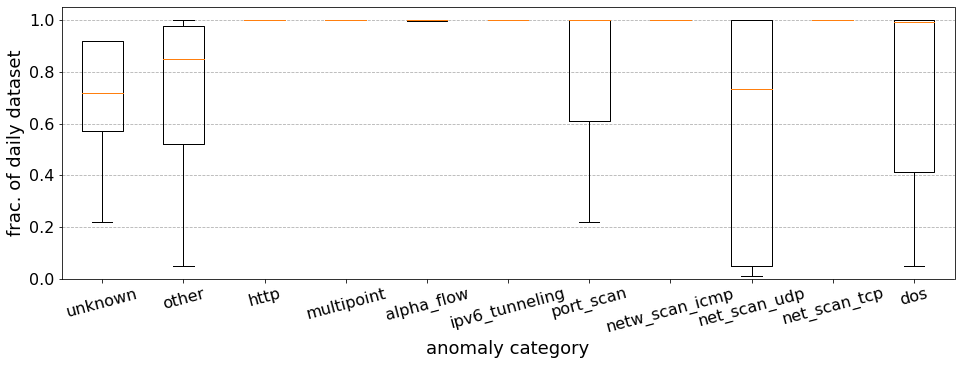

In [35]:
fig, ax= plt.subplots(1, 1, figsize=(16, 5))

boxplot = plt.boxplot(anomalies_major_duration_boxplot,showfliers=False)
xticks = ax.set_xticklabels(major_anomaly_categories, rotation=15)
#plt.title('Anomaly durations', fontsize = 16)
plt.ylabel('frac. of daily dataset',size = 14)
plt.xlabel('anomaly category',size = 14)
ax.set_ylim([0,1.05])
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=16)
plt.grid(which='major', axis='y',linestyle='--')
fig.savefig('mawi_major_anomaly_durations.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


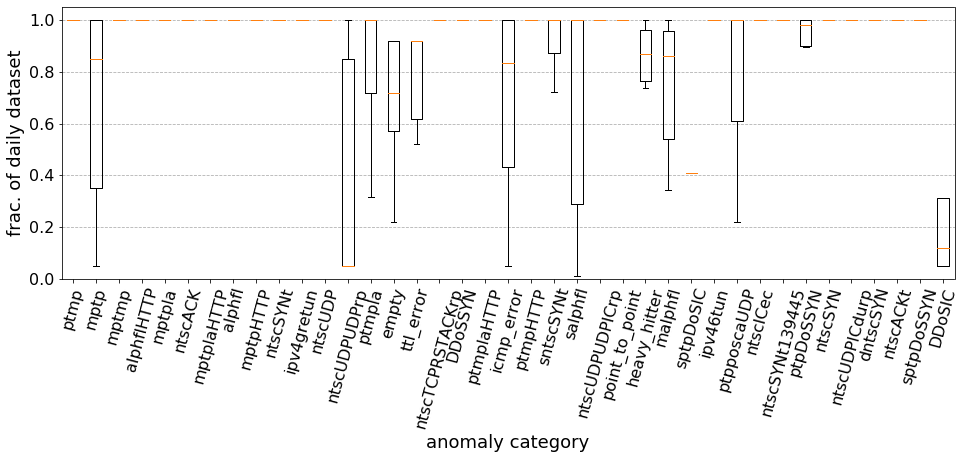

In [30]:
# boxplot of time_intervals

fig, ax= plt.subplots(1, 1, figsize=(16, 5))

# daily_time_interval = 15min (900s for unix timestamp)
daily_time_interval = 900
anomaly_categories = anomaly_pd['category'].unique()

boxplot = plt.boxplot([anomaly_pd['time_range'][anomaly_pd['category']==category]/daily_time_interval for category in anomaly_categories],showfliers=False)
xticks = ax.set_xticklabels(anomaly_categories, rotation=75)
#plt.title('Anomaly durations', fontsize = 16)
plt.ylabel('frac. of daily dataset',size = 14)
plt.xlabel('anomaly category',size = 14)
ax.set_ylim([0,1.05])
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=16)
plt.grid(which='major', axis='y',linestyle='--')
fig.savefig('mawi_anomaly_durations.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# 2.3 Anomaly multitude

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  from ipykernel import kernelapp as app


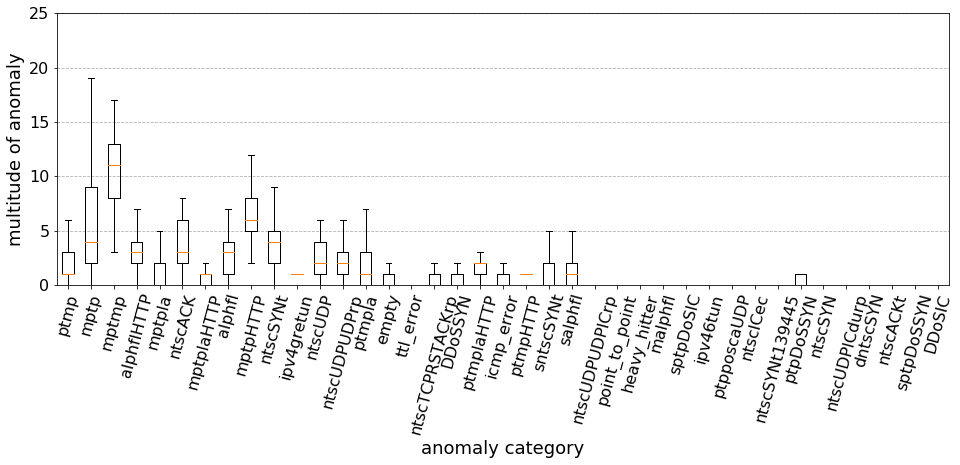

In [31]:
fig, ax= plt.subplots(1, 1, figsize=(16, 5))

anomaly_categories = list(ground_truth_pd.columns[:39])

boxplot = plt.boxplot([ground_truth_pd[category] for category in anomaly_categories],showfliers=False)
xticks = ax.set_xticklabels(anomaly_categories, rotation=75)
#plt.title('Anomaly durations', fontsize = 16)
plt.ylabel('multitude of anomaly',size = 14)
plt.xlabel('anomaly category',size = 14)
ax.set_ylim([0,25])
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=16)
plt.grid(which='major', axis='y',linestyle='--')
fig.savefig('mawi_anomaly_multitude.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  from ipykernel import kernelapp as app


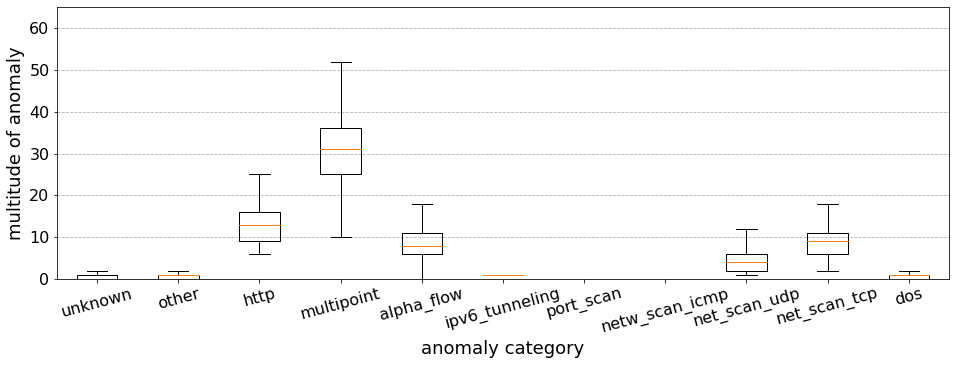

In [34]:
fig, ax= plt.subplots(1, 1, figsize=(16, 5))

major_anomaly_categories=list(ground_truth_pd.columns[39:-1])

boxplot = plt.boxplot([ground_truth_pd[category] for category in major_anomaly_categories],showfliers=False)
xticks = ax.set_xticklabels(major_anomaly_categories, rotation=15)
#plt.title('Anomaly durations', fontsize = 16)
plt.ylabel('multitude of anomaly',size = 14)
plt.xlabel('anomaly category',size = 14)
ax.set_ylim([0,65])
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=16)
plt.grid(which='major', axis='y',linestyle='--')
fig.savefig('mawi_major_anomaly_multitude.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

## 2.2 Anomaly cluster sizes

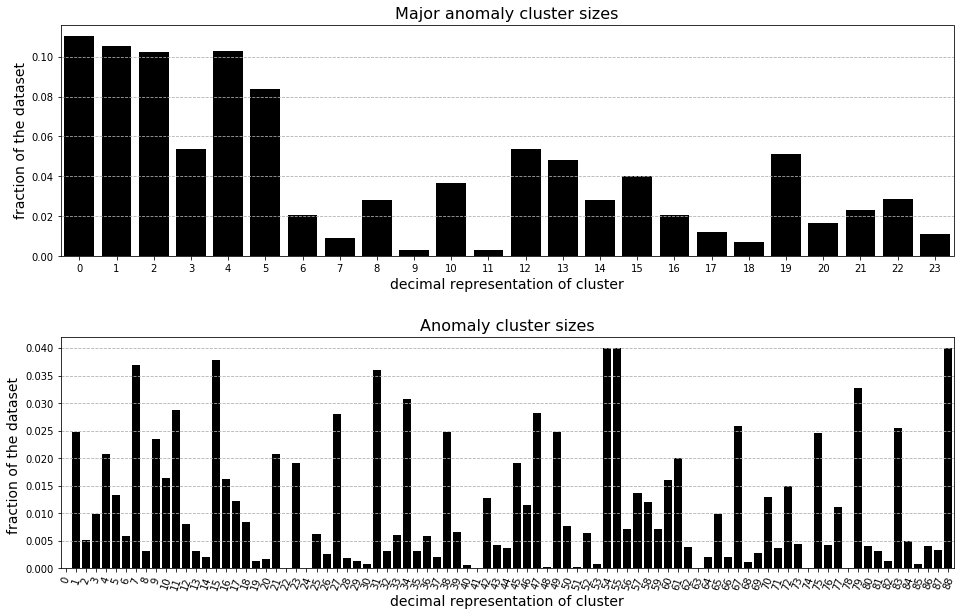

In [13]:
# unique cluster sizes boxplots - to gain some idea about the size of the anomaly clusters

fig, ax= plt.subplots(2, 1, figsize=(16, 10))

num_samples = float(len(ground_truth_pd_binary))
major_anomaly_clusters = ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'].unique()
anomaly_clusters = ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'].unique()

# sum occurence of each cluster
ax[0].bar(range(len(major_anomaly_clusters)),[ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled']==label].count()/num_samples for label in major_anomaly_clusters], color='black')
ax[0].set_xticks(range(len(major_anomaly_clusters)))
ax[0].set_xlim([-0.5,len(major_anomaly_clusters)-0.5])
ax[0].set_title('Major anomaly cluster sizes', fontsize = 16)
ax[0].set_ylabel('fraction of the dataset',size = 14)
ax[0].set_xlabel('decimal representation of cluster',size = 14)
ax[0].grid(which='major', axis='y',linestyle='--')

ax[1].bar(range(len(anomaly_clusters)),[ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled']==label].count()/num_samples for label in anomaly_clusters], color='black')
ax[1].set_xticks(range(len(anomaly_clusters)))
ax[1].set_xticklabels(range(len(anomaly_clusters)),rotation=70)
ax[1].set_xlim([-0.5,len(anomaly_clusters)-0.5])
ax[1].set_title('Anomaly cluster sizes', fontsize = 16)
ax[1].set_ylabel('fraction of the dataset ',size = 14)
ax[1].set_xlabel('decimal representation of cluster',size = 14)
ax[1].grid(which='major', axis='y',linestyle='--')
plt.subplots_adjust(hspace = 0.35)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


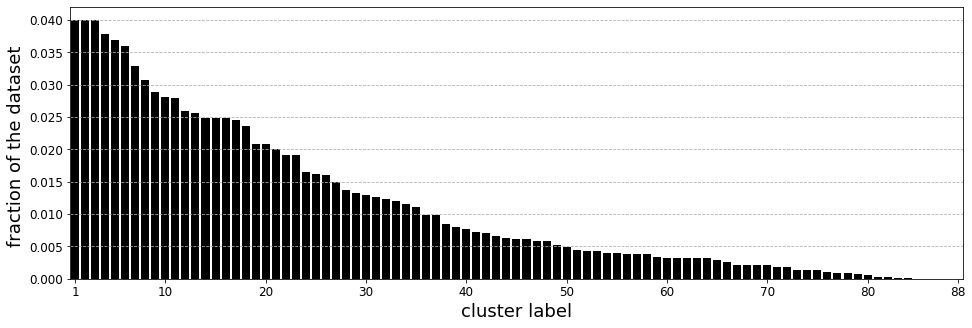

In [26]:
# unique cluster sizes boxplots - to gain some idea about the size of the anomaly clusters

fig, ax= plt.subplots(1, 1, figsize=(16, 5))

num_samples = float(len(ground_truth_pd_binary))
major_anomaly_clusters = ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'].unique()
anomaly_clusters = ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'].unique()

# sum occurence of each cluster
# ax.bar(range(len(major_anomaly_clusters)),np.sort([ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled']==label].count()/num_samples for label in major_anomaly_clusters])[::-1], color='black')
# ax.set_xticks([0,9,19,23])
# ax.set_xticklabels(['1','10','20','24'])
# ax.set_xlim([-0.5,len(major_anomaly_clusters)-0.5])
# #ax.set_title('Major anomaly cluster sizes', fontsize = 16)
# ax.set_ylabel('fraction of the dataset',size = 14)
# ax.set_xlabel('cluster label',size = 14)
# ax.grid(which='major', axis='y',linestyle='--')
# ax.xaxis.label.set_size(18)
# ax.yaxis.label.set_size(18)
# ax.tick_params(labelsize=12)
# fig.savefig('mawi_major_anomaly_cluster_sizes.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

ax.bar(range(len(anomaly_clusters)),np.sort([ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'][ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled']==label].count()/num_samples for label in anomaly_clusters])[::-1], color='black')
#ax.set_xticks(range(1,len(anomaly_clusters)))
ax.set_xticks([0,9,19,29,39,49,59,69,79,88])
ax.set_xticklabels(['1','10','20','30','40','50','60','70','80','88'])
ax.set_xlim([-0.5,len(anomaly_clusters)-0.5])
#ax.set_title('Anomaly cluster sizes', fontsize = 16)
ax.set_ylabel('fraction of the dataset ',size = 14)
ax.set_xlabel('cluster label',size = 14)
ax.grid(which='major', axis='y',linestyle='--')
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=12)
fig.savefig('mawi_anomaly_cluster_sizes.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

[Text(0,0,'')]

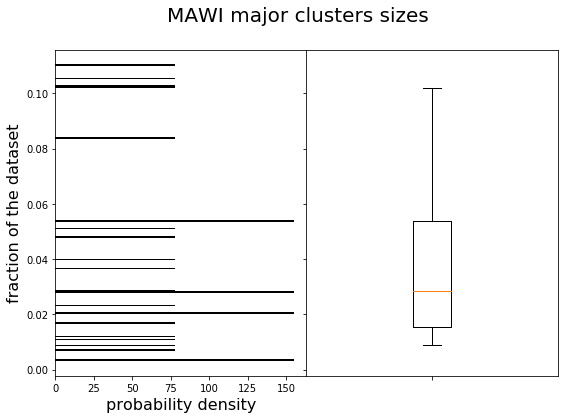

In [9]:
num_samples = float(len(ground_truth_pd_binary))
cluster_sizes = ground_truth_pd_binary['major_category_decimal_cluster_label_relabeled'].value_counts().values
cluster_sizes = cluster_sizes/num_samples

fig, [ax1,ax2]= plt.subplots(1, 2, sharey=True, figsize=(9, 6))
fig.subplots_adjust(wspace=0)
fig.suptitle('Major anomaly cluster sizes', size=20)
ax1.hist(cluster_sizes, color='black',bins = 200, density=True,orientation="horizontal")
ax1.set_xlabel('probability density', size=16)
ax1.set_ylabel('fraction of the dataset',size=16)


ax2.boxplot(cluster_sizes, whis=[10,90], showfliers=False)
ax2.set_xticklabels([''])

[Text(0,0,'')]

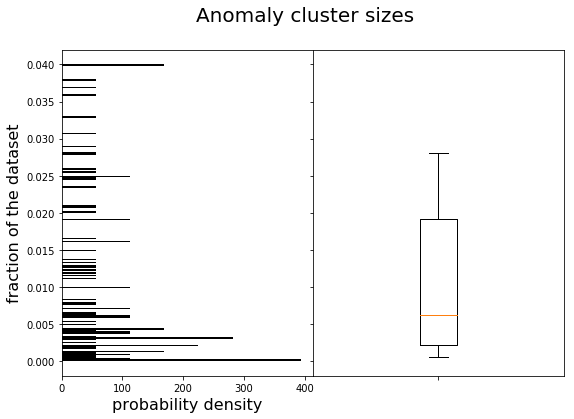

In [10]:
num_samples = float(len(ground_truth_pd_binary))
cluster_sizes = ground_truth_pd_binary['sub_category_decimal_cluster_label_relabeled'].value_counts().values
cluster_sizes = cluster_sizes/num_samples

fig, [ax1,ax2]= plt.subplots(1, 2, sharey=True, figsize=(9, 6))
fig.subplots_adjust(wspace=0)
fig.suptitle('Anomaly cluster sizes', size=20)
ax1.hist(cluster_sizes, color='black',bins = 200, density=True,orientation="horizontal")
ax1.set_xlabel('probability density', size=16)
ax1.set_ylabel('fraction of the dataset',size=16)


ax2.boxplot(cluster_sizes, whis=[10,90], showfliers=False)
ax2.set_xticklabels([''])

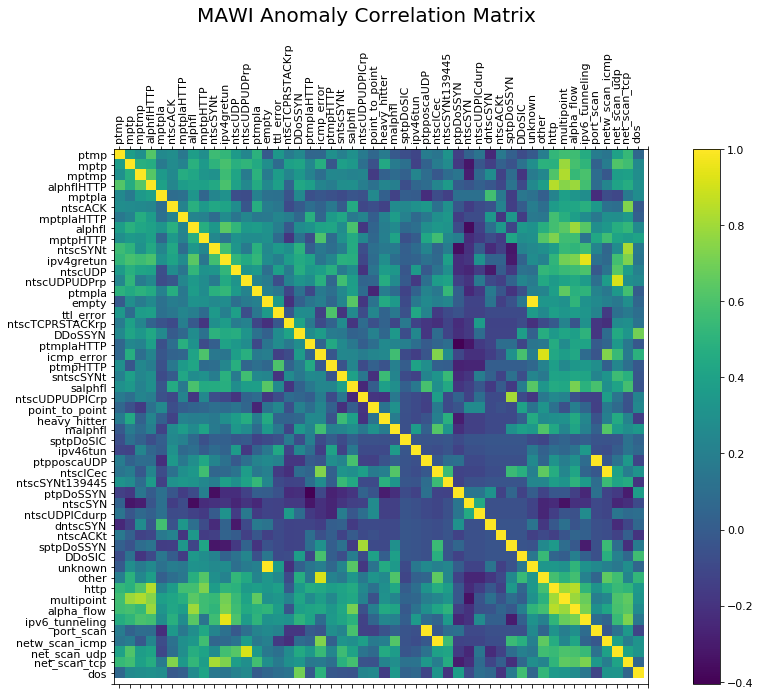

In [3]:
ground_truth_pd_corr = ground_truth_pd.corr()

fig, ax = plt.subplots(1, 1, figsize=(16, 11))
fig.suptitle('MAWI Anomaly Correlation Matrix', size=20)

heatmap = ax.matshow(ground_truth_pd_corr)
ax.set_xticks(range(ground_truth_pd.shape[1]))
ax.set_xticklabels(ground_truth_pd_corr.columns, fontsize=11, rotation=90)
ax.set_yticks(range(ground_truth_pd.shape[1]))
ax.set_yticklabels(ground_truth_pd_corr.columns, fontsize=11)
cb = fig.colorbar(heatmap)
cb.ax.tick_params(labelsize=11)
plt.subplots_adjust(top=0.80)